In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-08-15 16:30:33.672528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755275433.868395      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755275433.922480      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading the MNIST dataset
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 784) (60000,)
Test: (10000, 784) (10000,)
normalized_images shape:- (5923, 64)
shape 1:- (5923, 64, 64)
normalized_images shape:- (6742, 64)
shape 1:- (6742, 64, 64)
normalized_images shape:- (5958, 64)
shape 1:- (5958, 64, 64)
normalized_images shape:- (6131, 64)
shape 1:- (6131, 64, 64)
normalized_images shape:- (5842, 64)
shape 1:- (5842, 64, 64)
normalized_images shape:- (5421, 64)
shape 1:- (5421, 64, 64)
normalized_images shape:- (5918, 64)
shape 1:- (5918, 64, 64)
normalized_images shape:- (6265, 64)
shape 1:- (6265, 64, 64)
normalized_images shape:- (5851, 64)
shape 1:- (5851, 64, 64)
normalized_images shape:- (5949, 64)
shape 1:- (5949, 64, 64)


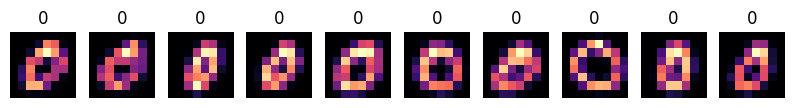

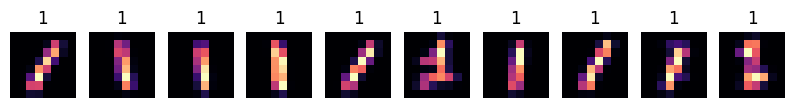

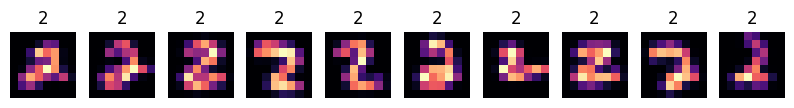

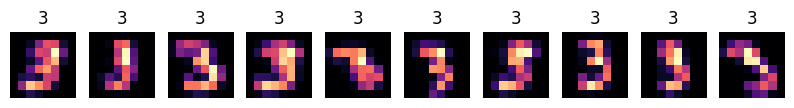

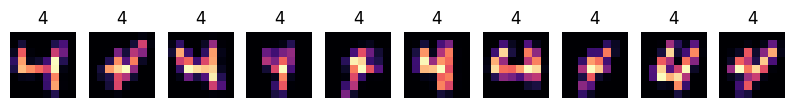

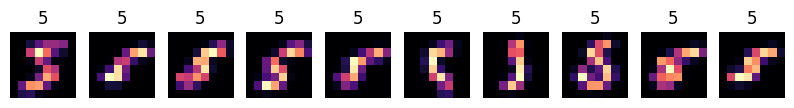

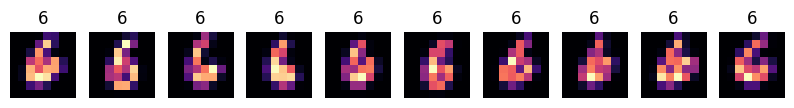

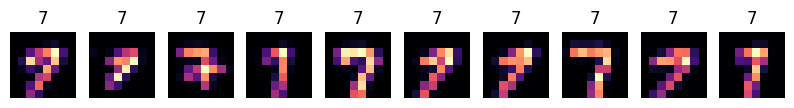

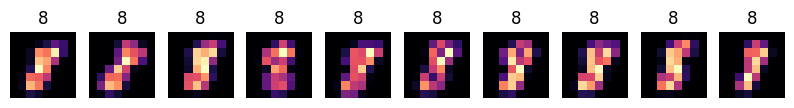

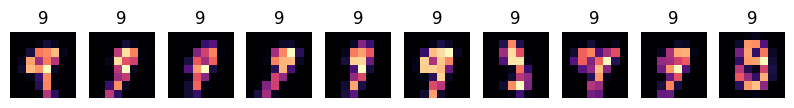

normalized_Hermitian_Digit_matrices shape:- torch.Size([60000, 64, 64])
normalized_hermitian_matrices_test_input shape:- torch.Size([10000, 64, 64])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [1]:
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
import torch
from sklearn.datasets import fetch_openml
import scipy

# ----------------------------
# Load MNIST from OpenML
# ----------------------------
# mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# mnist_images = mnist.data.astype(np.float64)   # (70000, 784)
# mnist_labels = mnist.target.astype(int)        # (70000,)

# x_train = mnist_images[:60000]
# y_train = mnist_labels[:60000]
# x_test  = mnist_images[60000:60201]
# y_test  = mnist_labels[60000:60201]

#OR

from tensorflow.keras.datasets import mnist

# Load MNIST using Keras
print("Loading the MNIST dataset")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# # Reshape and convert to float64 for consistency
x_train = x_train.reshape(-1, 784).astype(np.float64)
x_test = x_test.reshape(-1, 784).astype(np.float64)
print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

# ----------------------------
# Helper functions
# ----------------------------
def separate_digits(images, labels):
    """Group images by digit label."""
    digit_image = {d: [] for d in range(10)}
    for img, lbl in zip(images, labels):
        digit_image[lbl].append(img)
    return digit_image

def resize_images_batch(images, new_size=(8, 8), batch_size=500):
    """Resize a batch of flattened 28x28 images to new_size."""
    n = len(images)
    resized = []
    for i in range(0, n, batch_size):
        batch = images[i:i+batch_size]
        resized_batch = [resize(img.reshape(28,28), new_size).flatten() for img in batch]
        resized.extend(resized_batch)
    return np.array(resized)

def normalize_batch(images):
    """Normalize each image vector."""
    norms = np.linalg.norm(images, axis=1, keepdims=True)
    return images / norms

#Creating Hamiltonian using outer product method
def density_matrix_batch(images):
    """Convert vectors to density matrices."""
    return np.matmul(images[:,:,np.newaxis], images[:,np.newaxis,:])

#Creating the Hamiltonian using H = A + A.T/2 method
def hamiltonian_symmetric_batch(images):
  N,D = images.shape
  H_list = []
  for i in range(N):
    a = images[i]
    A = np.outer(a,np.ones(D))
    H = (A + A.conj().T) / 2
    H_list.append(H)

  return np.array(H_list)

#Creating the Hamiltonian using H = A @ A.T method
def hamiltonian_product_batch(images):
  N , D = images.shape
  H_list = []
  for i in range(N):
    a = images[i]
    A = np.outer(a,np.ones(D))
    H = A @ A.T
    H_list.append(H)
  return np.array(H_list)

import scipy.linalg
#Creating thr Hamiltonian using H = -i * log(V) method
def hamiltonian_using_log(images):
    # def make_unitary1(matrix):
    #     U, _, Vh = torch.linalg.svd(matrix, full_matrices=False)
    #     return U @ Vh
    
    # def make_unitary2(matrix):
    #     matrix = matrix / (torch.linalg.norm(matrix) + 1e-12) #for -i log(V) case only
    #     Q,R = torch.linalg.qr(matrix)
    #     return Q
            
    # N , D = images.shape
    # hamiltonians = np.zeros((N,D,D), dtype = np.complex128)
    # for i in range(N):
    #     image = images[i]
    #     mat = np.diag(image)
    #     mat_torch = torch.tensor(mat,dtype = torch.complex128)
    #     U_torch = make_unitary2(mat_torch)
    #     U_np = U_torch.detach().cpu().numpy()
    #     H = -1j * scipy.linalg.logm(U_np)
    #     H = (H + H.conj().T) / 2
    #     hamiltonians[i] = H

    # return hamiltonians
    def _make_hermitian(M):
        return 0.5 * (M + M.conj().transpose(-2,-1))

    def _make_unitary(M):
        H = _make_hermitian(M)
        return torch.matrix_exp(-1j*H)

    N,D = images.shape
    hamiltonians = np.zeros((N,D,D),dtype = np.complex128)
    for i in range(N):
        image = images[i]
        mat = np.diag(image)
        mat_torch = torch.tensor(mat,dtype = torch.complex128)
        H = _make_unitary(mat_torch)
        hamiltonians[i] = H
    return hamiltonians
        

    
        

# ----------------------------
# Process training data
# ----------------------------
digit_images_dict = separate_digits(x_train, y_train)
resized_digit_images = {}
normalized_digit_images = {}
density_matrices = {}

for digit, imgs in digit_images_dict.items():
    imgs = np.array(imgs)
    imgs_resized = resize_images_batch(imgs, new_size=(8,8), batch_size=500)
    imgs_normalized = normalize_batch(imgs_resized)
    print(f"normalized_images shape:- {imgs_normalized.shape}")
    density1 = density_matrix_batch(imgs_normalized)
    print(f"shape 1:- {density1.shape}")
    #OR
    #density2 = hamiltonian_symmetric_batch(imgs_normalized)
    #print(f"shape 2:- {density2.shape}")
    #OR
    #density3 = hamiltonian_product_batch(imgs_normalized)
    #print(f"shape 3:- {density3.shape}")
    #OR
    #density4 = hamiltonian_using_log(imgs_normalized)
    #print(f"shape 4:- {density4.shape}")
    density1 /= np.linalg.norm(density1, axis=(1,2), keepdims=True)
    #density2 /= np.linalg.norm(density2, axis=(1,2), keepdims=True)
    #density3 /= np.linalg.norm(density3, axis=(1,2), keepdims=True)
    #density4 /= np.linalg.norm(density4, axis=(1,2), keepdims=True)
    resized_digit_images[digit] = imgs_resized
    normalized_digit_images[digit] = imgs_normalized
    density_matrices[digit] = density1
    #density_matrices[digit] = density2
    #density_matrices[digit] = density3
    #density_matrices[digit] = density4

train_density_matrices = np.concatenate([density_matrices[d] for d in range(10)], axis=0)
train_density_matrices_tensor = torch.tensor(train_density_matrices, dtype=torch.cfloat)

# ----------------------------
# Process test data
# ----------------------------
test_images_resized = np.array([resize(img.reshape(28,28), (8,8)).flatten() for img in x_test])
test_normed = normalize_batch(test_images_resized)
test_density = density_matrix_batch(test_normed)
test_density /= np.linalg.norm(test_density, axis=(1,2), keepdims=True)
test_density_tensor = torch.tensor(test_density, dtype=torch.cfloat)

# ----------------------------
# Visualization example
# ---------------------------

for digit in range(10):
    images_to_plot = resized_digit_images[digit][:10]
    plt.figure(figsize=(10,2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images_to_plot[i].reshape(8,8), cmap='magma')
        plt.title(f"{digit}")
        plt.axis('off')
    plt.show()

normalized_Hermitian_Digit_matrices = train_density_matrices_tensor
# normalized_Hermitian_Digit_matrices = torch.tensor(train_subset,dtype = torch.cfloat)
normalized_hermitian_matrices_test_input = test_density_tensor
# normalized_hermitian_matrices_test_input = torch.tensor(test_subset,dtype = torch.cfloat)

print(f"normalized_Hermitian_Digit_matrices shape:- {normalized_Hermitian_Digit_matrices.shape}")
print(f"normalized_hermitian_matrices_test_input shape:- {normalized_hermitian_matrices_test_input.shape}")
# normalized_Hermitian_Digit_matrices_small = torch.tensor(train_subset_small,dtype = torch.cfloat)
# normalized_hermitian_matrices_test_input_small = torch.tensor(test_subset_small,dtype = torch.cfloat)


labels = []
for i in range(10):
    labels.append(i)

print(labels)

D = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
# D = [100] * 10
labels_zero = [labels[0]]*D[0]
labels_one  = [labels[1]]*D[1]
labels_two  = [labels[2]]*D[2]
labels_three  = [labels[3]]*D[3]
labels_four  = [labels[4]]*D[4]
labels_five  = [labels[5]]*D[5]
labels_six  = [labels[6]]*D[6]
labels_seven  = [labels[7]]*D[7]
labels_eigth  = [labels[8]]*D[8]
labels_nineth  = [labels[9]]*D[9]
labels_zero = np.array(labels_zero,dtype = int)
labels_one = np.array(labels_one,dtype = int)
labels_two = np.array(labels_two,dtype = int)
labels_three = np.array(labels_three,dtype = int)
labels_four = np.array(labels_four,dtype = int)
labels_five = np.array(labels_five,dtype = int)
labels_six = np.array(labels_six,dtype = int)
labels_seven = np.array(labels_seven,dtype = int)
labels_eigth = np.array(labels_eigth,dtype = int)
labels_nineth = np.array(labels_nineth,dtype = int)

labels_new_train = np.concatenate((labels_zero,labels_one))
labels_new_train = np.concatenate((labels_new_train,labels_two))
labels_new_train = np.concatenate((labels_new_train,labels_three))
labels_new_train = np.concatenate((labels_new_train,labels_four))
labels_new_train = np.concatenate((labels_new_train,labels_five))
labels_new_train = np.concatenate((labels_new_train,labels_six))
labels_new_train = np.concatenate((labels_new_train,labels_seven))
labels_new_train = np.concatenate((labels_new_train,labels_eigth))
labels_new_train = np.concatenate((labels_new_train,labels_nineth))

In [ ]:
Case 1

In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import time
# from typing import Tuple

# def set_seed(seed: int = 42) -> None:
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)

# class IntegratedHermitianClassifier(nn.Module):
#     """
#     Learns:
#         1. Hermitian base matrices  x, p
#         2. Complex coefficients  a_k  per training sample
#         3. A unitary matrix  U  that maps reconstructed Hamiltonians onto
#           class-specific target Hamiltonians.

#     Dual objectives (minimised together):
#         1. Frobenius norm between reconstructed and original Hamiltonians.
#         2. Frobenius norm between unitary-transformed reconstructions and
#            class target Hamiltonians.

#     Auxiliary term:
#         1. Unitary constraint ‖U U† - I‖_F  +  ‖U† U - I‖_F.
#     """

#     def __init__(
#         self,
#         matrix_size: int = 64,
#         d_order: int = 3,
#         lr: float = 1e-3,
#         epochs: int = 50,
#         batch_size: int = 128,
#         device: str = None,
#     ) -> None:
#         super().__init__()

#         # Hyper-parameters
#         self.n = matrix_size
#         self.d = d_order
#         self.lr = lr
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))

#         # Trainable Hermitian bases (small init for stability)
#         self.x = nn.Parameter(0.1 * torch.randn(matrix_size, matrix_size, dtype=torch.cfloat))
#         self.p = nn.Parameter(0.1 * torch.randn(matrix_size, matrix_size, dtype=torch.cfloat))

#         # Trainable unregularised matrix that will be exponentiated to unitary
#         self.U_param = nn.Parameter(torch.randn(matrix_size, matrix_size, dtype=torch.cfloat))

#         # Cached powers of  x  (x² … xᵈ)
#         self.register_buffer("powers", torch.zeros(d_order, matrix_size, matrix_size, dtype=torch.cfloat))
#         self._powers_computed = False

#         # Placeholders for data tensors
#         self.Mtr: torch.Tensor = None
#         self.Mte: torch.Tensor = None
#         self.y:   torch.Tensor = None
#         self.yte: torch.Tensor = None
#         self.target_matrices: torch.Tensor = None

#         self.to(self.device)

#     @staticmethod
#     def _make_hermitian(M: torch.Tensor) -> torch.Tensor:
#         return 0.5 * (M + M.conj().transpose(-2, -1))

#     @staticmethod
#     def _frobenius_norm(mat: torch.Tensor) -> torch.Tensor:
#         return torch.norm(mat, p="fro", dim=(-2, -1), keepdim=True) + 1e-8

#     def _normalise(self, M: torch.Tensor) -> torch.Tensor:
#         return M / self._frobenius_norm(M)

#     def make_unitary1(self,matrix):
#       U,_,Vh = torch.linalg.svd(matrix,full_matrices = False)
#       return U @ Vh

#     def make_unitary2(self,matrix):
#       Q,R = torch.linalg.qr(matrix)
#       return Q

#     def _make_unitary(self,matrix):
#       H = self._make_hermitian(matrix)
#       return torch.matrix_exp(-1j*H)

#     @torch.no_grad()
#     def _compute_powers(self) -> None:
#         x_herm = self._make_hermitian(self._normalise(self.x))

#         x_power = x_herm @ x_herm
#         self.powers[0] = x_power
#         for k in range(1, self.d):
#             x_power = x_power @ x_herm
#             self.powers[k] = x_power

#         self._powers_computed = True

#     def _base_hamiltonian(self) -> torch.Tensor:
#         x_h = self._make_hermitian(self._normalise(self.x))
#         p_h = self._make_hermitian(self._normalise(self.p))
#         return self._make_hermitian(0.5 * (p_h @ p_h) + 0.5 * (x_h @ x_h))

#     def _reconstruct_batch(self, coeffs: torch.Tensor) -> torch.Tensor:
#         """
#         Reconstruct Hamiltonians for a batch of coefficient vectors.
#         coeffs.shape == (batch, d)
#         """
#         if not self._powers_computed:
#             self._compute_powers()

#         H0 = self._base_hamiltonian()
#         batch = coeffs.shape[0]

#         recon = H0.unsqueeze(0).expand(batch, -1, -1).clone()
#         for k in range(self.d):
#             recon = recon + coeffs[:, k].unsqueeze(-1).unsqueeze(-1) * self.powers[k]
#         recon = 0.5 * (recon + recon.conj().transpose(-2, -1))
#         return recon

#     @staticmethod
#     def _frobenius_batch(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
#         diff = A - B
#         # ||A-B||_F² = Tr((A-B)†(A-B))
#         tr = torch.diagonal(diff.conj().transpose(-2, -1) @ diff, dim1=-2, dim2=-1).sum(-1)
#         return torch.abs(tr)  # shape: (batch,)

#     def load_data(
#         self,
#         train_mats: np.ndarray,
#         train_labels: np.ndarray,
#         test_mats: np.ndarray,
#         test_labels: np.ndarray,
#         target_mats: np.ndarray,
#     ) -> None:
#         print(f"Loading data on {self.device} …")

#         self.Mtr  = torch.as_tensor(train_mats, dtype=torch.cfloat, device=self.device)
#         self.y    = torch.as_tensor(train_labels, dtype=torch.long,  device=self.device)
#         self.Mte  = torch.as_tensor(test_mats,  dtype=torch.cfloat, device=self.device)
#         self.yte  = torch.as_tensor(test_labels, dtype=torch.long,  device=self.device)
#         self.target_matrices = torch.as_tensor(target_mats, dtype=torch.cfloat, device=self.device)

#         self._compute_powers()  # pre-compute x-powers once

#         print(
#             f"Data loaded — train {self.Mtr.shape}, test {self.Mte.shape}"
#         )

#     #Change here
#     def forward(
#         self,
#         coeffs: torch.Tensor,             # (batch, d)
#         originals: torch.Tensor,          # (batch, n, n)
#         targets: torch.Tensor,            # (batch, n, n)
#     ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

#         # 1 -  reconstruction loss
#         reconstructed = self._reconstruct_batch(coeffs)
#         L_recon = self._frobenius_batch(reconstructed, originals).mean()

#         # 2 -  unitary mapping loss
#         U = self.make_unitary1(self.U_param)
#         transformed = U @ reconstructed @ U.conj().transpose(-2, -1)
#         L_unitary = self._frobenius_batch(transformed, targets).mean()

#         # 3 -  unitary constraint
#         I = torch.eye(self.n, dtype=torch.cfloat, device=self.device)
#         L_uc0 = torch.norm(U @ U.conj().T - I, p="fro")
#         L_uc1 = torch.norm(U.conj().T @ U - I, p="fro")

#         # weighted total
#         total = L_recon + 10*L_unitary + 0.1 * (L_uc0 + L_uc1)
#         return total, L_recon, L_unitary, L_uc0, L_uc1

#     @torch.no_grad()
#     def accuracy(self, mats: torch.Tensor, labels: torch.Tensor) -> float:
#         U = self._make_unitary(self.U_param)
#         outs = U @ mats @ U.conj().transpose(-2, -1)
#         diag = torch.abs(torch.diagonal(outs, dim1=-2, dim2=-1))      # (batch, n)
#         preds = torch.argmax(diag, dim=-1) // 7                        # 10 classes (positions spaced by 7)
#         return torch.mean((preds == labels).float()).item()


# class ComplexCoefficients(nn.Module):
#     def __init__(self, d: int, n_samples: int, device: torch.device) -> None:
#         super().__init__()
#         std = 0.01 / np.sqrt(d)
#         self.real = nn.Parameter(std * torch.randn(n_samples, d, device=device))
#         self.imag = nn.Parameter(std * torch.randn(n_samples, d, device=device))

#     def forward(self, idx: torch.Tensor) -> torch.Tensor:
#         return torch.complex(self.real[idx], self.imag[idx])

#     # handy accessor
#     def all(self) -> torch.Tensor:
#         return torch.complex(self.real, self.imag)

# class ReduceLROnPlateau:
#     def __init__(self, optimiser: optim.Optimizer, factor: float = 0.5, patience: int = 3, min_lr: float = 1e-8):
#         self.opt = optimiser
#         self.factor = factor
#         self.patience = patience
#         self.min_lr = min_lr
#         self.best: float = None
#         self.bad_epochs = 0

#     def step(self, metric: float):
#         if self.best is None or metric < self.best:
#             self.best = metric
#             self.bad_epochs = 0
#             return
#         self.bad_epochs += 1
#         if self.bad_epochs >= self.patience:
#             for pg in self.opt.param_groups:
#                 new_lr = max(pg["lr"] * self.factor, self.min_lr)
#                 pg["lr"] = new_lr
#             self.bad_epochs = 0

# def create_target_matrices(labels: np.ndarray, matrix_size: int = 64) -> np.ndarray:
#     positions = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63]
#     out = np.zeros((len(labels), matrix_size, matrix_size), dtype=np.complex64)

#     for i, lab in enumerate(labels):
#         pos = positions[lab]
#         out[i, pos, pos] = 1.0

#     for i in range(len(out)):
#         norm = np.linalg.norm(out[i], 'fro')
#         if norm > 0:
#             out[i] = out[i] / norm

#     return out

# def train_model(model: IntegratedHermitianClassifier) -> torch.Tensor:
#     print("Training started …")
#     t0 = time.time()

#     N = model.Mtr.shape[0]
#     coeffs = ComplexCoefficients(model.d, N, model.device)

#     opt_coeff   = optim.Adam(coeffs.parameters(), lr=model.lr)
#     opt_bases   = optim.Adam([model.x, model.p], lr=model.lr * 0.1)
#     opt_unitary = optim.Adam([model.U_param],     lr=model.lr * 0.05)

#     sched_coeff   = ReduceLROnPlateau(opt_coeff)
#     sched_bases   = ReduceLROnPlateau(opt_bases)
#     sched_unitary = ReduceLROnPlateau(opt_unitary)

#     ds = TensorDataset(model.Mtr, model.target_matrices, torch.arange(N, device=model.device))
#     dl = DataLoader(ds, batch_size=model.batch_size, shuffle=True)

#     for epoch in range(1, model.epochs + 1):
#         print(f"Epoch: {epoch}")
#         loss_sum = recon_sum = unit_sum = 0.0
#         batches = 0

#         for orig, tgt, idx in dl:
#             a = coeffs(idx)

#             opt_coeff.zero_grad()
#             opt_bases.zero_grad()
#             opt_unitary.zero_grad()

#             tot, Lr, Lu, _, _ = model(a, orig, tgt)
#             tot.backward()

#             torch.nn.utils.clip_grad_norm_(coeffs.parameters(), 1.0)
#             torch.nn.utils.clip_grad_norm_([model.x, model.p], 0.5)
#             torch.nn.utils.clip_grad_norm_([model.U_param], 0.5)

#             opt_coeff.step()
#             opt_bases.step()
#             opt_unitary.step()

#             model._compute_powers()

#             loss_sum  += tot.item()
#             recon_sum += Lr.item()
#             unit_sum  += Lu.item()
#             batches   += 1

#         sched_coeff.step(loss_sum / batches)
#         sched_bases.step(recon_sum / batches)
#         sched_unitary.step(unit_sum / batches)

#         train_acc = model.accuracy(model.Mtr, model.y)
#         test_acc  = model.accuracy(model.Mte, model.yte)

#         print(
#             f"  Epoch {epoch:02d}/{model.epochs} | "
#             f"Loss {loss_sum / batches:.4e} | "
#             f"Recon {recon_sum / batches:.4e} | "
#             f"Unit {unit_sum / batches:.4e} | "
#             f"Acc train {train_acc:.3f} │ test {test_acc:.3f} | "
#             f"Δt {time.time()-t0:.1f}s"
#         )

#     print(f"✓ Training finished in {time.time() - t0:.1f}s")
#     return coeffs.all()


# def predict_coefficients(
#     model: IntegratedHermitianClassifier,
#     d_order: int,
#     lr: float = 1e-3,
#     epochs: int = 200,
#     batch_size: int = 2000,
# ) -> torch.Tensor:
#     print("► Predicting coefficients for test set …")
#     Nt = model.Mte.shape[0]
#     out = torch.empty((Nt, d_order), dtype=torch.cfloat, device=model.device)

#     ds = TensorDataset(model.Mte, torch.arange(Nt, device=model.device))
#     dl = DataLoader(ds, batch_size=batch_size)

#     for mats, idx in dl:
#         coeff = ComplexCoefficients(d_order, len(idx), model.device)
#         opt = optim.Adam(coeff.parameters(), lr=lr)

#         for _ in range(epochs):
#             opt.zero_grad()
#             preds = coeff(torch.arange(len(idx), device=model.device))
#             recon = model._reconstruct_batch(preds)
#             loss = model._frobenius_batch(recon, mats).mean()
#             loss.backward()
#             opt.step()

#         out[idx] = coeff.all()
#     print("✓ Coefficient prediction complete")
#     return out

# def run_pipeline(
#     train_mats: np.ndarray,
#     train_labels: np.ndarray,
#     test_mats: np.ndarray,
#     test_labels: np.ndarray,
#     *,
#     matrix_size: int = 64,
#     d_order: int = 10,
#     lr: float = 5e-3,
#     epochs: int = 50,
#     batch_size: int = 128
# ) -> Tuple[IntegratedHermitianClassifier, torch.Tensor, torch.Tensor]:

#     set_seed(42)

#     # Build class-specific target Hamiltonians
#     targets = create_target_matrices(train_labels, matrix_size)

#     # Initialise model and load data
#     model = IntegratedHermitianClassifier(
#         matrix_size=matrix_size,
#         d_order=d_order,
#         lr=lr,
#         epochs=epochs,
#         batch_size=batch_size,
#     )
#     model.load_data(train_mats, train_labels, test_mats, test_labels, targets)

#     # Train
#     train_coeffs = train_model(model)

#     # Predict test coefficients
#     test_coeffs = predict_coefficients(model, d_order, lr=lr * 0.1)

#     # # Persist artefacts
#     # save_results(train_coeffs, test_coeffs, model, out_dir)

#     # Final accuracies
#     print("\n================ FINAL ACCURACY ================ ")
#     print(f"Train: {model.accuracy(model.Mtr, model.y):.3%}")
#     print(f" Test: {model.accuracy(model.Mte, model.yte):.3%}")
#     print("===============================================\n")

#     return model, train_coeffs, test_coeffs

# def create_labels_from_class_counts(class_counts):
#     labels = []
#     for class_idx, count in enumerate(class_counts):
#         labels.extend([class_idx] * count)
#     return labels

# class_counts = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

# train_X = normalized_Hermitian_Digit_matrices.numpy()
# train_y = create_labels_from_class_counts(class_counts)
# test_X = normalized_hermitian_matrices_test_input.numpy()
# test_y = y_test

# run_pipeline(train_X, train_y, test_X, test_y, matrix_size = 64, d_order = 10, lr = 1e-1, epochs = 10, batch_size = 20)





Case 1 Updated code

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from typing import Tuple

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

class IntegratedHermitianClassifier(nn.Module):
    def __init__(
        self,
        matrix_size: int = 64,
        d_order: int = 3,
        lr: float = 1e-3,
        epochs: int = 50,
        batch_size: int = 128,
        device: str = None,
    ) -> None:
        super().__init__()

        # Hyper-parameters
        self.n = matrix_size
        self.d = d_order
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))

        # Trainable Hermitian bases (small init for stability)
        self.x = nn.Parameter(0.1 * torch.randn(matrix_size, matrix_size, dtype=torch.cfloat))
        self.p = nn.Parameter(0.1 * torch.randn(matrix_size, matrix_size, dtype=torch.cfloat))

        # Trainable unregularised matrix that will be exponentiated to unitary
        self.U_param = nn.Parameter(torch.randn(matrix_size, matrix_size, dtype=torch.cfloat))

        # Cached powers of  x  (x² … xᵈ)
        self.register_buffer("powers", torch.zeros(d_order, matrix_size, matrix_size, dtype=torch.cfloat))
        self._powers_computed = False

        # Placeholders for data tensors
        self.Mtr: torch.Tensor = None
        self.Mte: torch.Tensor = None
        self.y:   torch.Tensor = None
        self.yte: torch.Tensor = None
        self.target_matrices: torch.Tensor = None

        self.to(self.device)

    @staticmethod
    def _make_hermitian(M: torch.Tensor) -> torch.Tensor:
        return 0.5 * (M + M.conj().transpose(-2, -1))

    @staticmethod
    def _frobenius_norm(mat: torch.Tensor) -> torch.Tensor:
        return torch.norm(mat, p="fro", dim=(-2, -1), keepdim=True) + 1e-8

    def _normalise(self, M: torch.Tensor) -> torch.Tensor:
        return M / self._frobenius_norm(M)

    # def _make_unitary(self, matrix):
    #     U, _, Vh = torch.linalg.svd(matrix, full_matrices=False)
    #     return U @ Vh

    # Other Methods of Enforcing Unitary COnstraints that can be tried...
    # def _make_unitary(self, matrix):
    #     Q, R = torch.linalg.qr(matrix)
    #     return Q

    def _make_unitary(self, M: torch.Tensor) -> torch.Tensor:
        """
        Generates a unitary matrix through matrix exponential of a Hermitian:
            U = exp(-i H),  H = (M + M†)/2
        """
        H = self._make_hermitian(M)
        return torch.matrix_exp(-1j * H)

    @torch.no_grad()
    def _compute_powers(self) -> None:
        x_herm = self._make_hermitian(self._normalise(self.x))

        x_power = x_herm @ x_herm
        self.powers[0] = x_power
        for k in range(1, self.d):
            x_power = x_power @ x_herm
            self.powers[k] = x_power

        self._powers_computed = True

    def _base_hamiltonian(self) -> torch.Tensor:
        x_h = self._make_hermitian(self._normalise(self.x))
        p_h = self._make_hermitian(self._normalise(self.p))
        return self._make_hermitian(0.5 * (p_h @ p_h) + 0.5 * (x_h @ x_h))

    def _reconstruct_batch(self, coeffs: torch.Tensor) -> torch.Tensor:
        """
        Reconstruct Hamiltonians for a batch of coefficient vectors.
        coeffs.shape == (batch, d)
        """
        if not self._powers_computed:
            self._compute_powers()

        H0 = self._base_hamiltonian()
        batch = coeffs.shape[0]

        recon = H0.unsqueeze(0).expand(batch, -1, -1).clone()
        for k in range(self.d):
            recon = recon + coeffs[:, k].unsqueeze(-1).unsqueeze(-1) * self.powers[k]
        recon = 0.5 * (recon + recon.conj().transpose(-2, -1))
        return recon

    @staticmethod
    def _frobenius_batch(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
        diff = A - B
        # ||A-B||_F² = Tr((A-B)†(A-B))
        tr = torch.diagonal(diff.conj().transpose(-2, -1) @ diff, dim1=-2, dim2=-1).sum(-1)
        return torch.abs(tr)  # shape: (batch,)

    def load_data(
        self,
        train_mats: np.ndarray,
        train_labels: np.ndarray,
        test_mats: np.ndarray,
        test_labels: np.ndarray,
        target_mats: np.ndarray,
    ) -> None:
        print(f"► Loading data on {self.device} …")

        self.Mtr  = torch.as_tensor(train_mats, dtype=torch.cfloat, device=self.device)
        self.y    = torch.as_tensor(train_labels, dtype=torch.long,  device=self.device)
        self.Mte  = torch.as_tensor(test_mats,  dtype=torch.cfloat, device=self.device)
        self.yte  = torch.as_tensor(test_labels, dtype=torch.long,  device=self.device)
        self.target_matrices = torch.as_tensor(target_mats, dtype=torch.cfloat, device=self.device)

        self._compute_powers()  # pre-compute x-powers once

        print(
            f"✓ Data loaded — train {self.Mtr.shape}, test {self.Mte.shape}"
        )

    def forward(
        self,
        coeffs: torch.Tensor,             # (batch, d)
        originals: torch.Tensor,          # (batch, n, n)
        targets: torch.Tensor,            # (batch, n, n)
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

        # 1 -  reconstruction loss
        reconstructed = self._reconstruct_batch(coeffs)
        L_recon = self._frobenius_batch(reconstructed, originals).mean()

        # 2 -  unitary mapping loss
        U = self._make_unitary(self.U_param)
        transformed = U @ reconstructed @ U.conj().transpose(-2, -1)
        L_unitary = self._frobenius_batch(transformed, targets).mean()

        # 3 -  unitary constraint
        I = torch.eye(self.n, dtype=torch.cfloat, device=self.device)
        L_uc0 = torch.norm(U @ U.conj().T - I, p="fro")
        L_uc1 = torch.norm(U.conj().T @ U - I, p="fro")

        # weighted total
        total = L_recon + 10*L_unitary + 0.1 * (L_uc0 + L_uc1)
        return total, L_recon, L_unitary, L_uc0, L_uc1

    @torch.no_grad()
    def accuracy(self, mats: torch.Tensor, labels: torch.Tensor) -> float:
        U = self._make_unitary(self.U_param)
        outs = U @ mats @ U.conj().transpose(-2, -1)
        diag = torch.abs(torch.diagonal(outs, dim1=-2, dim2=-1))      # (batch, n)
        preds = torch.argmax(diag, dim=-1) // 7                        # 10 classes (positions spaced by 7)
        return torch.mean((preds == labels).float()).item()

class ComplexCoefficients(nn.Module):
    def __init__(self, d: int, n_samples: int, device: torch.device) -> None:
        super().__init__()
        std = 0.01 / np.sqrt(d)
        self.real = nn.Parameter(std * torch.randn(n_samples, d, device=device))
        self.imag = nn.Parameter(std * torch.randn(n_samples, d, device=device))

    def forward(self, idx: torch.Tensor) -> torch.Tensor:
        return torch.complex(self.real[idx], self.imag[idx])

    # handy accessor
    def all(self) -> torch.Tensor:
        return torch.complex(self.real, self.imag)

class ReduceLROnPlateau:
    def __init__(self, optimiser: optim.Optimizer, factor: float = 0.5, patience: int = 3, min_lr: float = 1e-8):
        self.opt = optimiser
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best: float = None
        self.bad_epochs = 0

    def step(self, metric: float):
        if self.best is None or metric < self.best:
            self.best = metric
            self.bad_epochs = 0
            return
        self.bad_epochs += 1
        if self.bad_epochs >= self.patience:
            for pg in self.opt.param_groups:
                new_lr = max(pg["lr"] * self.factor, self.min_lr)
                pg["lr"] = new_lr
            self.bad_epochs = 0


def create_target_matrices(labels: np.ndarray, matrix_size: int = 64) -> np.ndarray:
    positions = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63]
    out = np.zeros((len(labels), matrix_size, matrix_size), dtype=np.complex64)
    
    for i, lab in enumerate(labels):
        pos = positions[lab]
        out[i, pos, pos] = 1.0

    for i in range(len(out)):
        norm = np.linalg.norm(out[i], 'fro')
        if norm > 0:
            out[i] = out[i] / norm
    
    return out


def train_model(model: IntegratedHermitianClassifier) -> torch.Tensor:
    print("► Training started …")
    t0 = time.time()

    N = model.Mtr.shape[0]
    coeffs = ComplexCoefficients(model.d, N, model.device)

    opt_coeff   = optim.Adam(coeffs.parameters(), lr=model.lr)
    opt_bases   = optim.Adam([model.x, model.p], lr=model.lr * 0.1)
    opt_unitary = optim.Adam([model.U_param],     lr=model.lr * 0.05)

    sched_coeff   = ReduceLROnPlateau(opt_coeff)
    sched_bases   = ReduceLROnPlateau(opt_bases)
    sched_unitary = ReduceLROnPlateau(opt_unitary)

    ds = TensorDataset(model.Mtr, model.target_matrices, torch.arange(N, device=model.device))
    dl = DataLoader(ds, batch_size=model.batch_size, shuffle=True)

    for epoch in range(1, model.epochs + 1):
        print(f"Epoch: {epoch}")
        loss_sum = recon_sum = unit_sum = 0.0
        batches = 0

        for orig, tgt, idx in dl:
            a = coeffs(idx)

            opt_coeff.zero_grad()
            opt_bases.zero_grad()
            opt_unitary.zero_grad()

            tot, Lr, Lu, _, _ = model(a, orig, tgt)
            tot.backward()

            torch.nn.utils.clip_grad_norm_(coeffs.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_([model.x, model.p], 0.5)
            torch.nn.utils.clip_grad_norm_([model.U_param], 0.5)

            opt_coeff.step()
            opt_bases.step()
            opt_unitary.step()

            model._compute_powers()  

            loss_sum  += tot.item()
            recon_sum += Lr.item()
            unit_sum  += Lu.item()
            batches   += 1

        sched_coeff.step(loss_sum / batches)
        sched_bases.step(recon_sum / batches)
        sched_unitary.step(unit_sum / batches)

        train_acc = model.accuracy(model.Mtr, model.y)
        test_acc  = model.accuracy(model.Mte, model.yte)

        print(
            f"  Epoch {epoch:02d}/{model.epochs} | "
            f"Loss {loss_sum / batches:.4e} | "
            f"Recon {recon_sum / batches:.4e} | "
            f"Unit {unit_sum / batches:.4e} | "
            f"Acc train {train_acc:.3f} │ test {test_acc:.3f} | "
            f"Δt {time.time()-t0:.1f}s"
        )

    print(f"✓ Training finished in {time.time() - t0:.1f}s")
    return coeffs.all()


# @torch.no_grad()
def predict_coefficients(
    model: IntegratedHermitianClassifier,
    d_order: int,
    lr: float = 1e-3,
    epochs: int = 200,
    batch_size: int = 2000,
) -> torch.Tensor:
    print("► Predicting coefficients for test set …")
    Nt = model.Mte.shape[0]
    out = torch.empty((Nt, d_order), dtype=torch.cfloat, device=model.device)

    ds = TensorDataset(model.Mte, torch.arange(Nt, device=model.device))
    dl = DataLoader(ds, batch_size=batch_size)

    for mats, idx in dl:
        coeff = ComplexCoefficients(d_order, len(idx), model.device)
        opt = optim.Adam(coeff.parameters(), lr=lr)

        for _ in range(epochs):
            opt.zero_grad()
            preds = coeff(torch.arange(len(idx), device=model.device))
            recon = model._reconstruct_batch(preds)
            loss = model._frobenius_batch(recon, mats).mean()
            loss.backward()
            opt.step()

        out[idx] = coeff.all()
    print("✓ Coefficient prediction complete")
    return out

def run_pipeline(
    train_mats: np.ndarray,
    train_labels: np.ndarray,
    test_mats: np.ndarray,
    test_labels: np.ndarray,
    *,
    matrix_size: int = 64,
    d_order: int = 10,
    lr: float = 5e-3,
    epochs: int = 50,
    batch_size: int = 128,
    out_dir: str = "./",
) -> Tuple[IntegratedHermitianClassifier, torch.Tensor, torch.Tensor]:

    set_seed(42)

    # Build class-specific target Hamiltonians
    targets = create_target_matrices(train_labels, matrix_size)

    # Initialise model and load data
    model = IntegratedHermitianClassifier(
        matrix_size=matrix_size,
        d_order=d_order,
        lr=lr,
        epochs=epochs,
        batch_size=batch_size,
    )
    model.load_data(train_mats, train_labels, test_mats, test_labels, targets)

    # Train
    train_coeffs = train_model(model)

    # Predict test coefficients
    #test_coeffs = predict_coefficients(model, d_order, lr=lr * 0.1)

    # # Persist artefacts
    # save_results(train_coeffs, test_coeffs, model, out_dir)

    # Final accuracies
    print("\n================ FINAL ACCURACY ================ ")
    print(f"Train: {model.accuracy(model.Mtr, model.y):.3%}")
    print(f" Test: {model.accuracy(model.Mte, model.yte):.3%}")
    print("===============================================\n")

    return model, train_coeffs, test_coeffs


def create_labels_from_class_counts(class_counts):
    labels = []
    for class_idx, count in enumerate(class_counts):
        labels.extend([class_idx] * count)
    return labels

class_counts = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

train_X = normalized_Hermitian_Digit_matrices.numpy()
train_y = create_labels_from_class_counts(class_counts)
test_X = normalized_hermitian_matrices_test_input.numpy()
test_y = y_test

run_pipeline(train_X, train_y, test_X, test_y, matrix_size = 64, d_order = 50, lr = 1e-1, epochs = 10, batch_size = 100)

Case 2

In [ ]:
!pip uninstall optree

In [3]:
from __future__ import annotations
import time
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


class IntegratedHermitianClassifier(nn.Module):
    def __init__(
        self,
        matrix_size: int = 64,
        n_classes: int = 10,
        d_order: int = 10,
        lr: float = 2e-3,
        epochs: int = 100,
        batch_size: int = 512,
        device: str | None = None,
    ) -> None:
        super().__init__()

        self.n, self.C, self.d = matrix_size, n_classes, d_order
        self.lr, self.epochs, self.batch_size = lr, epochs, batch_size
        self.device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))

        # class-wise Hermitian bases  (x_c , p_c)  → Parameters (C,n,n)
        self.x_cls = nn.Parameter(0.1 * torch.randn(self.C, self.n, self.n, dtype=torch.cfloat))
        self.p_cls = nn.Parameter(0.1 * torch.randn(self.C, self.n, self.n, dtype=torch.cfloat))

        # global unconstrained parameter whose exponential is unitary
        self.U_param = nn.Parameter(torch.randn(self.n, self.n, dtype=torch.cfloat))

        # data placeholders
        self.Mtr = self.Mte = self.y = self.yte = self.target_mats = None  

        self.to(self.device)

    @staticmethod
    def _make_hermitian(M: torch.Tensor) -> torch.Tensor:
        return 0.5 * (M + M.conj().transpose(-2, -1))

    @staticmethod
    def _fro(M: torch.Tensor) -> torch.Tensor:
        return torch.norm(M, p="fro", dim=(-2, -1), keepdim=True) + 1e-8

    def _unitary(self) -> torch.Tensor:
        H = self._make_hermitian(self.U_param)
        return torch.matrix_exp(-1j * H)

    def _reconstruct(
        self,
        coeffs: torch.Tensor,      # (B,d)
        x_b:   torch.Tensor,       # (B,n,n)  — already class-selected
        p_b:   torch.Tensor,       # (B,n,n)
    ) -> torch.Tensor:
        """Vectorised reconstruction for a batch."""
        B = coeffs.shape[0]
        x_h = self._make_hermitian(self._normalise(x_b := self._normalise(x_b)))
        p_h = self._make_hermitian(self._normalise(p_b := self._normalise(p_b)))

        H0 = self._make_hermitian(0.5 * (p_h @ p_h) + 0.5 * (x_h @ x_h))
        powers = []
        x_pow = x_h @ x_h
        powers.append(x_pow)
        for _ in range(1, self.d):
            x_pow = x_pow @ x_h
            powers.append(x_pow)

        recon = H0.clone()
        for k in range(self.d):
            recon = recon + coeffs[:, k].view(B, 1, 1) * powers[k]
        recon = 0.5 * (recon + recon.conj().transpose(-2, -1))
        return recon

    def _normalise(self, M: torch.Tensor) -> torch.Tensor:
        return M / self._fro(M)

    def forward(
        self,
        coeffs: torch.Tensor,      # (B,d)
        labels: torch.Tensor,      # (B,)
        originals: torch.Tensor,   # (B,n,n)
        targets: torch.Tensor,     # (B,n,n)
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

        x_b = self.x_cls[labels]
        p_b = self.p_cls[labels]
        recon = self._reconstruct(coeffs, x_b, p_b)

        diff     = recon - originals
        L_recon  = torch.diagonal(diff.conj().transpose(-2, -1) @ diff,
                                  dim1=-2, dim2=-1).sum(-1).abs().mean()

        U  = self._unitary()
        Uh = U.conj().transpose(-2, -1)
        diffU = U @ recon @ Uh - targets
        L_unit = torch.diagonal(diffU.conj().transpose(-2, -1) @ diffU,
                                dim1=-2, dim2=-1).sum(-1).abs().mean()

        I = torch.eye(self.n, dtype=torch.cfloat, device=self.device)
        L_uc = torch.norm(U @ Uh - I, p="fro") + torch.norm(Uh @ U - I, p="fro")

        total = L_recon + L_unit #+ 0.1 * L_uc
        return total, L_recon, L_unit, L_uc

    @torch.no_grad()
    def accuracy_diag(self, mats: torch.Tensor, labels: torch.Tensor) -> float:
        """Quick diagnostic accuracy – diag( UHU† )."""
        U = self._unitary()
        outs = U @ mats @ U.conj().transpose(-2, -1)
        preds = torch.diagonal(outs.abs(), dim1=-2, dim2=-1).argmax(-1) // 7
        return (preds == labels).float().mean().item()

    def load_data(
        self,
        train_mats: np.ndarray,
        train_labels: np.ndarray,
        test_mats:  np.ndarray,
        test_labels: np.ndarray,
        target_mats: np.ndarray,
    ) -> None:
        print(f"► Loading data on {self.device} …")

        self.Mtr = torch.tensor(train_mats, dtype=torch.cfloat, device=self.device)
        self.y   = torch.tensor(train_labels, dtype=torch.long, device=self.device)
        self.Mte = torch.tensor(test_mats,  dtype=torch.cfloat, device=self.device)
        self.yte = torch.tensor(test_labels, dtype=torch.long, device=self.device)
        self.target_mats = torch.tensor(target_mats, dtype=torch.cfloat, device=self.device)

        print(f"Data loaded — train {self.Mtr.shape}, test {self.Mte.shape}")


class ComplexCoefficients(nn.Module):
    def __init__(self, d: int, n_samples: int, device: torch.device):
        super().__init__()
        std = 0.01 / np.sqrt(d)
        self.real = nn.Parameter(std * torch.randn(n_samples, d, device=device))
        self.imag = nn.Parameter(std * torch.randn(n_samples, d, device=device))

    def forward(self, idx: torch.Tensor) -> torch.Tensor:
        return torch.complex(self.real[idx], self.imag[idx])

    def all(self) -> torch.Tensor:
        return torch.complex(self.real, self.imag)

class ReduceLROnPlateau:
    def __init__(self, opt: optim.Optimizer, factor=.5, patience=3, min_lr=1e-8):
        self.opt, self.factor, self.patience, self.min_lr = opt, factor, patience, min_lr
        self.best, self.bad = None, 0

    def step(self, metric: float):
        if self.best is None or metric < self.best:
            self.best, self.bad = metric, 0
            return
        self.bad += 1
        if self.bad >= self.patience:
            for pg in self.opt.param_groups:
                pg["lr"] = max(pg["lr"] * self.factor, self.min_lr)
            self.bad = 0

def create_target_matrices(labels: np.ndarray | List[int], n: int = 64) -> np.ndarray:
    pos = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63]
    out = np.zeros((len(labels), n, n), np.complex64)
    for i, lab in enumerate(labels):
        out[i, pos[lab], pos[lab]] = 1.0
    out /= np.linalg.norm(out, axis=(-2, -1), keepdims=True, ord='fro')
    return out


def train(model: IntegratedHermitianClassifier) -> torch.Tensor:
    print("► Training …")
    t0 = time.time()

    N = model.Mtr.shape[0]
    coeffs = ComplexCoefficients(model.d, N, model.device)

    opt_coeff = optim.Adam(coeffs.parameters(), lr=model.lr)
    opt_bases = optim.Adam([model.x_cls, model.p_cls], lr=model.lr * .1)
    opt_unit  = optim.Adam([model.U_param],             lr=model.lr * .05)

    sch_coeff = ReduceLROnPlateau(opt_coeff)
    sch_bases = ReduceLROnPlateau(opt_bases)
    sch_unit  = ReduceLROnPlateau(opt_unit)

    ds = TensorDataset(model.Mtr, model.target_mats, model.y, torch.arange(N, device=model.device))
    dl = DataLoader(ds, batch_size=model.batch_size, shuffle=True)

    for ep in range(1, model.epochs + 1):
        print(f"Epoch: {ep}")
        tot_sum = rec_sum = unit_sum = 0.0; batches = 0
        for H, T, lab, idx in dl:
            a = coeffs(idx)

            opt_coeff.zero_grad(); opt_bases.zero_grad(); opt_unit.zero_grad()
            tot, Lr, Lu, L_uc = model(a, lab, H, T)
            tot.backward()

            torch.nn.utils.clip_grad_norm_(coeffs.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_([model.x_cls, model.p_cls], .5)
            torch.nn.utils.clip_grad_norm_([model.U_param], .5)

            opt_coeff.step(); opt_bases.step(); opt_unit.step()

            tot_sum += tot.item(); rec_sum += Lr.item(); unit_sum += Lu.item()
            batches += 1

        sch_coeff.step(tot_sum / batches)
        sch_bases.step(rec_sum / batches)
        sch_unit.step(unit_sum / batches)

        print(f"  Ep {ep:03d}/{model.epochs} | "
              f"Loss {tot_sum/batches:.4e} | "
              f"Recon {rec_sum/batches:.4e} | "
              f"Unit {unit_sum/batches:.4e} | "
              f"Acc {model.accuracy_diag(model.Mtr, model.y):.3f} │ "
              f"Δt {time.time()-t0:.1f}s")

    print("Done  (training time {:.1f}s)".format(time.time()-t0))
    return coeffs.all()


def classify_test_set(
    model: IntegratedHermitianClassifier,
    d_order: int,
    lr: float = 1e-3,
    epochs: int = 100,
    batch_size: int = 10000,
    tol_target: float = 1e-3,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Returns
    -------
    coeffs_out : (N_test,d)  coefficients of the chosen class per sample
    preds      : (N_test,)   predicted class labels
    """
    print("Classifying test set …")
    N = model.Mte.shape[0]
    coeffs_out = torch.empty((N, d_order), dtype=torch.cfloat, device=model.device)
    preds      = torch.empty(N, dtype=torch.long, device=model.device)

    # pre-compute class targets (C,n,n)
    tgt_cls = torch.tensor(create_target_matrices(list(range(model.C)), model.n),
                           dtype=torch.cfloat, device=model.device)
    U  = model._unitary()
    Uh = U.conj().transpose(-2, -1)

    ds = TensorDataset(model.Mte, torch.arange(N, device=model.device))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    for H_batch, idx_batch in dl:
        for j, idx in enumerate(idx_batch):
            H = H_batch[j:j+1]     

            best_match_loss = torch.inf
            best_nomatch_loss = torch.inf
            best_coeff = None
            best_class = None
            matched = False

            for c in range(model.C):
                coeff = ComplexCoefficients(d_order, 1, model.device)
                opt   = optim.Adam(coeff.parameters(), lr=lr)

                x_c = model.x_cls[c:c+1]  # (1,n,n)
                p_c = model.p_cls[c:c+1]

                for _ in range(epochs):
                    opt.zero_grad()
                    a = coeff(torch.tensor([0], device=model.device))
                    recon = model._reconstruct(a, x_c, p_c)
                    loss = (recon - H).abs().pow(2).sum()
                    loss.backward()
                    opt.step()

                a_opt = coeff.all()  # (1,d)
                recon = model._reconstruct(a_opt, x_c, p_c)
                rec_loss = (recon - H).abs().pow(2).sum().item()

                out = U @ recon @ Uh
                tgt_diff = (out - tgt_cls[c:c+1]).abs().pow(2).sum().item()

                if tgt_diff < tol_target:      # criterion 1 satisfied
                    matched = True
                    if rec_loss < best_match_loss:
                        best_match_loss = rec_loss
                        best_coeff, best_class = a_opt.squeeze(0), c
                elif not matched and rec_loss < best_nomatch_loss:
                    best_nomatch_loss = rec_loss
                    best_coeff, best_class = a_opt.squeeze(0), c

            coeffs_out[idx] = best_coeff
            preds[idx]      = best_class

    print("Classification complete")
    return coeffs_out, preds


def run_pipeline(
    train_mats: np.ndarray,
    train_labels: np.ndarray,
    test_mats:  np.ndarray,
    test_labels: np.ndarray,
    *,
    matrix_size: int = 64,
    d_order: int = 10,
    lr: float = 5e-3,
    epochs: int = 200,
    batch_size: int = 1024,
) -> Tuple[IntegratedHermitianClassifier, torch.Tensor, torch.Tensor, torch.Tensor]:

    set_seed(42)

    tgt_train = create_target_matrices(train_labels, matrix_size)

    model = IntegratedHermitianClassifier(
        matrix_size=matrix_size,
        d_order=d_order,
        lr=lr,
        epochs=epochs,
        batch_size=batch_size,
    )
    model.load_data(train_mats, train_labels, test_mats, test_labels, tgt_train)

    coeff_tr = train(model)
    #coeff_te, preds_te = classify_test_set(model, d_order, lr=lr*0.1)

    print(f" Train diag-acc  : {model.accuracy_diag(model.Mtr, model.y):.3%}")
    print(f" Test  diag-acc  : {model.accuracy_diag(model.Mte, model.yte):.3%}")
    #print(f" Test  class-acc : {(preds_te.cpu().numpy()==test_labels).mean():.3%}")

    return model, coeff_tr, coeff_te, preds_te




Case 2 GPU

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class IntegratedHermitianClassifier(nn.Module):
    def __init__(
        self,
        matrix_size: int = 64,
        n_classes: int = 10,
        d_order: int = 10,
        lr: float = 2e-3,
        epochs: int = 100,
        batch_size: int = 512,
        device: str | None = None,
    ) -> None:
        super().__init__()

        self.n, self.C, self.d = matrix_size, n_classes, d_order
        self.lr, self.epochs, self.batch_size = lr, epochs, batch_size
        self.device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))

        # class-wise Hermitian bases  (x_c , p_c) → Parameters (C,n,n)
        self.x_cls = nn.Parameter(0.1 * torch.randn(self.C, self.n, self.n, dtype=torch.cfloat, device=self.device))
        self.p_cls = nn.Parameter(0.1 * torch.randn(self.C, self.n, self.n, dtype=torch.cfloat, device=self.device))

        # global unconstrained parameter whose exponential is unitary
        self.U_param = nn.Parameter(torch.randn(self.n, self.n, dtype=torch.cfloat, device=self.device))

        # data placeholders
        self.Mtr = self.Mte = self.y = self.yte = self.target_mats = None  

        self.to(self.device)

    @staticmethod
    def _make_hermitian(M: torch.Tensor) -> torch.Tensor:
        return 0.5 * (M + M.conj().transpose(-2, -1))

    @staticmethod
    def _fro(M: torch.Tensor) -> torch.Tensor:
        return torch.norm(M, p="fro", dim=(-2, -1), keepdim=True) + 1e-8

    def _unitary(self) -> torch.Tensor:
        H = self._make_hermitian(self.U_param)
        return torch.matrix_exp(-1j * H)

    def _reconstruct(
        self,
        coeffs: torch.Tensor,      # (B,d)
        x_b:   torch.Tensor,       # (B,n,n)  — already class-selected
        p_b:   torch.Tensor,       # (B,n,n)
    ) -> torch.Tensor:
        """Vectorised reconstruction for a batch."""
        B = coeffs.shape[0]
        x_h = self._make_hermitian(self._normalise(x_b := self._normalise(x_b)))
        p_h = self._make_hermitian(self._normalise(p_b := self._normalise(p_b)))

        H0 = self._make_hermitian(0.5 * (p_h @ p_h) + 0.5 * (x_h @ x_h))
        powers = []
        x_pow = x_h @ x_h
        powers.append(x_pow)
        for _ in range(1, self.d):
            x_pow = x_pow @ x_h
            powers.append(x_pow)

        recon = H0.clone()
        for k in range(self.d):
            recon = recon + coeffs[:, k].view(B, 1, 1) * powers[k]
        recon = 0.5 * (recon + recon.conj().transpose(-2, -1))
        return recon

    def _normalise(self, M: torch.Tensor) -> torch.Tensor:
        return M / self._fro(M)

    def forward(
        self,
        coeffs: torch.Tensor,      # (B,d)
        labels: torch.Tensor,      # (B,)
        originals: torch.Tensor,   # (B,n,n)
        targets: torch.Tensor,     # (B,n,n)
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

        x_b = self.x_cls[labels]
        p_b = self.p_cls[labels]
        recon = self._reconstruct(coeffs, x_b, p_b)

        diff     = recon - originals
        L_recon  = torch.diagonal(diff.conj().transpose(-2, -1) @ diff,
                                  dim1=-2, dim2=-1).sum(-1).abs().mean()

        U  = self._unitary()
        Uh = U.conj().transpose(-2, -1)
        diffU = U @ recon @ Uh - targets
        L_unit = torch.diagonal(diffU.conj().transpose(-2, -1) @ diffU,
                                dim1=-2, dim2=-1).sum(-1).abs().mean()

        I = torch.eye(self.n, dtype=torch.cfloat, device=self.device)
        L_uc = torch.norm(U @ Uh - I, p="fro") + torch.norm(Uh @ U - I, p="fro")

        total = L_recon + L_unit #+ 0.1 * L_uc
        return total, L_recon, L_unit, L_uc

    @torch.no_grad()
    def accuracy_diag(self, mats: torch.Tensor, labels: torch.Tensor) -> float:
        """Quick diagnostic accuracy – diag( UHU† )."""
        U = self._unitary()
        outs = U @ mats @ U.conj().transpose(-2, -1)
        preds = torch.diagonal(outs.abs(), dim1=-2, dim2=-1).argmax(-1) // 7
        return (preds == labels).float().mean().item()

    def load_data(
        self,
        train_mats: np.ndarray,
        train_labels: np.ndarray,
        test_mats:  np.ndarray,
        test_labels: np.ndarray,
        target_mats: np.ndarray,
    ) -> None:
        print(f"► Loading data on {self.device} …")

        self.Mtr = torch.tensor(train_mats, dtype=torch.cfloat, device=self.device)
        self.y   = torch.tensor(train_labels, dtype=torch.long, device=self.device)
        self.Mte = torch.tensor(test_mats,  dtype=torch.cfloat, device=self.device)
        self.yte = torch.tensor(test_labels, dtype=torch.long, device=self.device)
        self.target_mats = torch.tensor(target_mats, dtype=torch.cfloat, device=self.device)

        print(f"Data loaded — train {self.Mtr.shape}, test {self.Mte.shape}")


    
    # ... (rest of your class unchanged, since it already uses self.device) ...


def train(model: IntegratedHermitianClassifier) -> torch.Tensor:
    print("► Training …")
    t0 = time.time()

    N = model.Mtr.shape[0]
    coeffs = ComplexCoefficients(model.d, N, model.device).to(model.device)

    opt_coeff = optim.Adam(coeffs.parameters(), lr=model.lr)
    opt_bases = optim.Adam([model.x_cls, model.p_cls], lr=model.lr * .1)
    opt_unit  = optim.Adam([model.U_param],             lr=model.lr * .05)

    sch_coeff = ReduceLROnPlateau(opt_coeff)
    sch_bases = ReduceLROnPlateau(opt_bases)
    sch_unit  = ReduceLROnPlateau(opt_unit)

    ds = TensorDataset(model.Mtr, model.target_mats, model.y, torch.arange(N, device=model.device))
    dl = DataLoader(ds, batch_size=model.batch_size, shuffle=True)

    for ep in range(1, model.epochs + 1):
        print(f"Epoch: {ep}")
        tot_sum = rec_sum = unit_sum = 0.0; batches = 0
        for H, T, lab, idx in dl:
            # make sure batch is on GPU
            H, T, lab, idx = H.to(model.device), T.to(model.device), lab.to(model.device), idx.to(model.device)

            a = coeffs(idx)

            opt_coeff.zero_grad(); opt_bases.zero_grad(); opt_unit.zero_grad()
            tot, Lr, Lu, L_uc = model(a, lab, H, T)
            tot.backward()

            torch.nn.utils.clip_grad_norm_(coeffs.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_([model.x_cls, model.p_cls], .5)
            torch.nn.utils.clip_grad_norm_([model.U_param], .5)

            opt_coeff.step(); opt_bases.step(); opt_unit.step()

            tot_sum += tot.item(); rec_sum += Lr.item(); unit_sum += Lu.item()
            batches += 1

        sch_coeff.step(tot_sum / batches)
        sch_bases.step(rec_sum / batches)
        sch_unit.step(unit_sum / batches)

        print(f"  Ep {ep:03d}/{model.epochs} | "
              f"Loss {tot_sum/batches:.4e} | "
              f"Recon {rec_sum/batches:.4e} | "
              f"Unit {unit_sum/batches:.4e} | "
              f"Acc {model.accuracy_diag(model.Mtr, model.y):.3f} │ "
              f"Δt {time.time()-t0:.1f}s")

    print("Done  (training time {:.1f}s)".format(time.time()-t0))
    return coeffs.all()


def classify_test_set(
    model: IntegratedHermitianClassifier,
    d_order: int,
    lr: float = 1e-3,
    epochs: int = 100,
    batch_size: int = 10000,
    tol_target: float = 1e-3,
) -> Tuple[torch.Tensor, torch.Tensor]:

    print("Classifying test set …")
    N = model.Mte.shape[0]
    coeffs_out = torch.empty((N, d_order), dtype=torch.cfloat, device=model.device)
    preds      = torch.empty(N, dtype=torch.long, device=model.device)

    # pre-compute class targets (C,n,n)
    tgt_cls = torch.tensor(create_target_matrices(list(range(model.C)), model.n),
                           dtype=torch.cfloat, device=model.device)
    U  = model._unitary()
    Uh = U.conj().transpose(-2, -1)

    ds = TensorDataset(model.Mte, torch.arange(N, device=model.device))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    for H_batch, idx_batch in dl:
        H_batch, idx_batch = H_batch.to(model.device), idx_batch.to(model.device)

        for j, idx in enumerate(idx_batch):
            H = H_batch[j:j+1].to(model.device)

            best_match_loss = torch.inf
            best_nomatch_loss = torch.inf
            best_coeff = None
            best_class = None
            matched = False

            for c in range(model.C):
                coeff = ComplexCoefficients(d_order, 1, model.device).to(model.device)
                opt   = optim.Adam(coeff.parameters(), lr=lr)

                x_c = model.x_cls[c:c+1].to(model.device)  # (1,n,n)
                p_c = model.p_cls[c:c+1].to(model.device)

                for _ in range(epochs):
                    opt.zero_grad()
                    a = coeff(torch.tensor([0], device=model.device))
                    recon = model._reconstruct(a, x_c, p_c)
                    loss = (recon - H).abs().pow(2).sum()
                    loss.backward()
                    opt.step()

                a_opt = coeff.all()  # (1,d)
                recon = model._reconstruct(a_opt, x_c, p_c)
                rec_loss = (recon - H).abs().pow(2).sum().item()

                out = U @ recon @ Uh
                tgt_diff = (out - tgt_cls[c:c+1]).abs().pow(2).sum().item()

                if tgt_diff < tol_target:
                    matched = True
                    if rec_loss < best_match_loss:
                        best_match_loss = rec_loss
                        best_coeff, best_class = a_opt.squeeze(0), c
                elif not matched and rec_loss < best_nomatch_loss:
                    best_nomatch_loss = rec_loss
                    best_coeff, best_class = a_opt.squeeze(0), c

            coeffs_out[idx] = best_coeff
            preds[idx]      = best_class

    print("Classification complete")
    return coeffs_out, preds


def create_labels_from_class_counts(class_counts):
    labels = []
    for class_idx, count in enumerate(class_counts):
        labels.extend([class_idx] * count)
    return labels

class_counts = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

train_X = normalized_Hermitian_Digit_matrices.numpy()
train_y = create_labels_from_class_counts(class_counts)
test_X = normalized_hermitian_matrices_test_input.numpy()
test_y = y_test

run_pipeline(train_X, train_y, test_X, test_y, matrix_size = 64, d_order = 90, lr = 1e-1, epochs = 10, batch_size = 100)



► Loading data on cuda …
Data loaded — train torch.Size([60000, 64, 64]), test torch.Size([10000, 64, 64])
► Training …
Epoch: 1
  Ep 001/10 | Loss 9.4986e-01 | Recon 6.7640e-01 | Unit 2.7346e-01 | Acc 0.650 │ Δt 37.3s
Epoch: 2
  Ep 002/10 | Loss 6.2142e+00 | Recon 3.2500e+00 | Unit 2.9643e+00 | Acc 0.716 │ Δt 70.8s
Epoch: 3
  Ep 003/10 | Loss 9.8836e-01 | Recon 6.5283e-01 | Unit 3.3553e-01 | Acc 0.711 │ Δt 104.8s
Epoch: 4
  Ep 004/10 | Loss 9.2122e-01 | Recon 6.3455e-01 | Unit 2.8667e-01 | Acc 0.669 │ Δt 139.6s
Epoch: 5
  Ep 005/10 | Loss 8.9683e-01 | Recon 6.3019e-01 | Unit 2.6664e-01 | Acc 0.660 │ Δt 174.1s
Epoch: 6
  Ep 006/10 | Loss 8.9357e-01 | Recon 6.2969e-01 | Unit 2.6388e-01 | Acc 0.670 │ Δt 208.7s
Epoch: 7
  Ep 007/10 | Loss 8.8905e-01 | Recon 6.2609e-01 | Unit 2.6296e-01 | Acc 0.668 │ Δt 243.2s
Epoch: 8
  Ep 008/10 | Loss 8.8595e-01 | Recon 6.2325e-01 | Unit 2.6270e-01 | Acc 0.677 │ Δt 277.7s
Epoch: 9
  Ep 009/10 | Loss 8.8434e-01 | Recon 6.2013e-01 | Unit 2.6421e-01 | Acc 

NameError: name 'coeff_te' is not defined

In [13]:
import torch

torch.cuda.empty_cache()   # releases all unused cached memory back to the GPU


NameError: name 'tensor_name' is not defined

In [14]:
print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  11901 MiB |  11901 MiB |   1966 GiB |   1954 GiB |
|       from large pool |  11889 MiB |  11889 MiB |   1954 GiB |   1942 GiB |
|       from small pool |     11 MiB |     11 MiB |     11 GiB |     11 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  11901 MiB |  11901 MiB |   1966 GiB |   1954 GiB |
|       from large pool |  11889 MiB |  11889 MiB |   1954 GiB |